In [29]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [30]:
###################################
# TensorFlow wizardry
import tensorflow as tf
config = tf.ConfigProto()
 
# Don’t pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.05
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
 
# Create a session with the above options specified.
from keras import optimizers, regularizers
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout, Input
from keras import backend as k

k.tensorflow_backend.set_session(tf.Session(config=config))
#k.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
###################################

In [31]:
#----------------------------------Import modules------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn import preprocessing
sns.set_style("whitegrid")
np.random.seed(23)
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from datetime import datetime 
import os.path

dsnum=20
verbose_level=1

In [32]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [33]:
pathds = os.path.abspath('/home/user/01Code/00Datasets_final/00BalancedDS')
file_name = "HalfCloneID"+str(dsnum)+"bal_stdscal.csv"
full_path = os.path.join(pathds,file_name)
print(full_path)

/home/user/01Code/00Datasets_final/00BalancedDS/HalfCloneID20bal_stdscal.csv


In [34]:
df = pd.read_csv(full_path)

In [35]:
df.shape

(1342432, 67)

In [36]:
neurons=df.shape[1]-1
batch_size=df.shape[1]-1
print(neurons)
print(batch_size)

66
66


#### 4.2 Explaining the data

In [37]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['class'], sort = True)
print('Class 0:', count_classes[0])
print('Class 1:', count_classes[1])
print('Proportion:', round(count_classes[0] / count_classes[1], 3), ': 1')

Class 0: 671216
Class 1: 671216
Proportion: 1.0 : 1


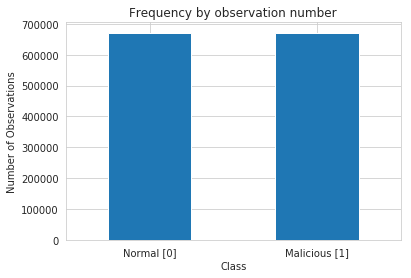

In [38]:
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normal [0]','Malicious [1]'])
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [39]:
#set random seed and percentage of test data
RANDOM_SEED = 23 #used to help randomly select the data points
TEST_PCT = 0.20 # 20% of the data

In [40]:
train, test_df = train_test_split(df, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ df -> original dataset 
+ train -> subset of 80% from original dataset 
+ test_df -> subset of 20% from original dataset 

In [41]:
train_df, dev_df = train_test_split(train, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ train -> subset of 80% from original dataset 
+ train_df -> subset of 80% from train
+ dev_df -> subset of 20% from train

In [42]:
# Check distribution of mal samples in train and test set
print(train_df.iloc[:, batch_size].sum()/train_df.shape[0]) 
print(dev_df.iloc[:, batch_size].sum()/dev_df.shape[0]) 
print(test_df.iloc[:, batch_size].sum()/test_df.shape[0])

0.5008648022012301
0.4985497395117999
0.49839284583611126


In [43]:
train_x = train_df.iloc[:, :batch_size] 
dev_x = dev_df.iloc[:, :batch_size] 
test_x = test_df.iloc[:, :batch_size] 

+ train_x -> features of train_df **Training subset for AE**
+ dev_x -> features of dev_df **Validation subset for AE**
+ test_x -> features of test_df **Testing subset for ANN**

In [44]:
# Define the final train and test sets
train_y = train_df.iloc[:,batch_size]
dev_y = dev_df.iloc[:,batch_size]
test_y = test_df.iloc[:,batch_size]

+ train_y -> **Labels for supervised training of ANN**
+ dev_y -> labels of dev_df  *not used for AE neither ANN*
+ test_y -> labels of test_df  **Ground Truth for predictions of supervised ANN**

In [45]:
train_x =np.array(train_x)
dev_x =np.array(dev_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
dev_y = np.array(dev_y)
test_y = np.array(test_y)

print(train_x.shape[1])

66


### Autoencoder Function

In [46]:
def ae(factor_enc_dim, enc_activation, dec_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer #RELU
    encoded = Dense(encoding_dim, activation=enc_activation, name='encoded_bottle_neck')(input_data)
    ### Define decoding layer #SIMOID
    decoded = Dense(train_x.shape[1], activation=dec_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [47]:
def spae(factor_enc_dim,dec_activation,enc_activation,
         optimizer,loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activity_regularizer=regularizers.l1(1e-4), activation=enc_activation, name='encoded_bottle_neck')(input_data)
    ### Define decoding layer
    decoded = Dense(train_x.shape[1], activation=dec_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [48]:
def to_pca(thr):
    #train_x_pca,test_x_pca = to_pca(0.95)
    pca = PCA(n_components = thr, svd_solver = 'full')
    train_x_ = np.array(train_x)
    print(type(train_x_))

    test_x_ = np.array(test_x)
    print(type(test_x_))
    
    start_time = time.time()
    print(time.ctime(start_time))

    train_x_pca = pca.fit_transform(train_x_)
    print(train_x_pca.shape)

    test_x_pca = pca.fit_transform(test_x_)
    print(test_x_pca.shape)

    elapsed_time = (time.time() - start_time)

    print("--- PCA spent %s seconds ---" %elapsed_time )
    
    return  train_x_pca,test_x_pca

In [49]:
def fit_ae(checkpoint_file, autoencoder,
           epochs, batch_size, shuffle):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=verbose_level)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = datetime.now()
    print(datetime.ctime(start_time))

    hist_auto = autoencoder.fit(train_x, train_x,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    verbose=verbose_level,
                    callbacks=[early_stopping, cp, tb],
                    validation_data=(dev_x, dev_x))

    time_elapsed = datetime.now() - start_time 
    print("Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))
    
    return hist_auto

In [50]:
def plot_hist_auto(hist_auto, fig_file):
    best_loss_value = hist_auto.history['loss'][-1]
    print('Best loss value:', best_loss_value)

    # Summarize history for loss
    plt.figure()
    plt.plot(hist_auto.history['loss'])
    plt.plot(hist_auto.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig(fig_file)
    plt.show()
    
    return best_loss_value

In [51]:
def ann_2h(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(int(neurons-int(neurons/4)), activation="relu", kernel_initializer=init_mode)) #rezvy

    model.add(Dense(int(neurons-int((neurons/4)*2)), activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [52]:
def ann_2h_():

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=input_dim,
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(int(neurons-int(neurons/4)), activation="relu", kernel_initializer=init_mode)) #rezvy

    model.add(Dense(int(neurons-int((neurons/4)*2)), activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [53]:
def ann_fit(checkpoint_file,ann,enc_train_x,train_y,epochs,shuffle,batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=verbose_level)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = datetime.now()
    print(datetime.ctime(start_time))

    history = ann.fit(enc_train_x,
                      train_y,
                      validation_split=0.2,
                      callbacks=[early_stopping, cp, tb],
                      epochs=epochs,
                      shuffle=shuffle,
                      batch_size=batch_size,
                      verbose=verbose_level)

    time_elapsed = datetime.now() - start_time 
    print("Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))

    return history

In [54]:
def ann_predict(ann,enc_test_x):
    pred_ann_prob = ann.predict(enc_test_x)
    pred_ann_prob.shape
    pred_ann_prob = pred_ann_prob[:,0]
    pred_ann_01 = np.where(pred_ann_prob > 0.5, 1, 0)
    
    #Print accuracy
    acc_ann = accuracy_score(test_y, pred_ann_01)
    print('Overall accuracy of Neural Network model:', acc_ann)

    classiBM = "NN"
    preBM = (sm.precision_score(test_y, pred_ann_01)*100) 
    recallBM = (sm.recall_score(test_y, pred_ann_01)*100) 
    f1scoreBM = (sm.f1_score(test_y, pred_ann_01)*100)
    print(sm.classification_report(test_y, pred_ann_01,digits=4))
    
    return pred_ann_prob, pred_ann_01

In [55]:
def ann_predict_():
    early_stopping = EarlyStopping(monitor='loss', patience=10)

    start_time = datetime.now()
    print(datetime.ctime(start_time))  

    modelk = KerasClassifier(build_fn=ann_2h_,
                             epochs=epochs, 
                             batch_size=batch_size, 
                             verbose=verbose_level
                            )

    pred_ann_prob = cross_val_predict(modelk,
                                      enc_test_x,
                                      test_y,
                                      cv=KFold(n_splits=5, random_state=23),
                                      verbose=1)

    time_elapsed = datetime.now() - start_time 
    print("Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))

    pred_ann_prob.shape
    pred_ann_prob = pred_ann_prob[:,0]
    pred_ann_01 = np.where(pred_ann_prob > 0.5, 1, 0)

    #Print accuracy
    acc_ann = accuracy_score(test_y, pred_ann_01)
    print('Overall accuracy of Neural Network model:', acc_ann)

    classiBM = "NN"
    preBM = (sm.precision_score(test_y, pred_ann_01)*100) 
    recallBM = (sm.recall_score(test_y, pred_ann_01)*100) 
    f1scoreBM = (sm.f1_score(test_y, pred_ann_01)*100)
    print(sm.classification_report(test_y, pred_ann_01,digits=4))
    
    return pred_ann_prob,pred_ann_01

In [56]:
def plot_roc_cm(pred_ann_prob, pred_ann_01, roc_file, cm_file):
    false_positive_rate, recall, thresholds = roc_curve(test_y, pred_ann_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.savefig(roc_file)
    plt.show()
    
    cm = confusion_matrix(test_y, pred_ann_01)
    labels = ['Normal', 'Malicious']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="RdYlGn", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig(cm_file)
    plt.show()

### **---------- PCA Dimensionality reduction ----------**

In [57]:
# train_x_pca,test_x_pca = to_pca(0.95)

### **---------- AE Dimensionality reduction ----------**

In [58]:
ae_sigmoid_adam_mse,enc_train_x_asam,enc_test_x_asam = ae(factor_enc_dim = 1.5,
                                                          enc_activation = 'relu',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 44)                2948      
_________________________________________________________________
dense_1 (Dense)              (None, 66)                2970      
Total params: 5,918
Trainable params: 5,918
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
#ae_sigmoid_adam_mse = load_model('ae_sigmoid_adam_mse_redds10bal.h5')

In [60]:
hist_ae_sigmoid_adam_mse = fit_ae(checkpoint_file = "./H5files/ae_sigmoid_adam_mse_redds"+str(dsnum)+"bal.h5",
                                  autoencoder = ae_sigmoid_adam_mse, 
                                  epochs = 200, 
                                  batch_size = batch_size,
                                  shuffle = False)

Tue Jul  9 13:18:35 2019
Instructions for updating:
Use tf.cast instead.
Train on 859156 samples, validate on 214789 samples
Epoch 1/200
859156/859156 [==============================] - 23s 26us/step - loss: 0.1617 - acc: 0.1883 - val_loss: 0.1556 - val_acc: 0.1867

Epoch 00001: val_loss improved from inf to 0.15563, saving model to ./H5files/ae_sigmoid_adam_mse_redds20bal.h5
Epoch 2/200
859156/859156 [==============================] - 22s 26us/step - loss: 0.1573 - acc: 0.1715 - val_loss: 0.1556 - val_acc: 0.1554

Epoch 00002: val_loss improved from 0.15563 to 0.15561, saving model to ./H5files/ae_sigmoid_adam_mse_redds20bal.h5
Epoch 3/200
859156/859156 [==============================] - 22s 26us/step - loss: 0.1573 - acc: 0.1584 - val_loss: 0.1556 - val_acc: 0.1712

Epoch 00003: val_loss improved from 0.15561 to 0.15561, saving model to ./H5files/ae_sigmoid_adam_mse_redds20bal.h5
Epoch 4/200
859156/859156 [==============================] - 22s 26us/step - loss: 0.1573 - acc: 0.1774 -

Best loss value: 0.15721022270130805


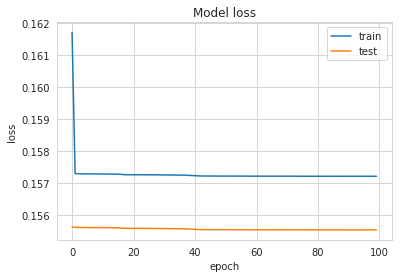

In [61]:
best_loss_value_ae_sigmoid_adam_mse  = plot_hist_auto(hist_ae_sigmoid_adam_mse, './Figures/hist_ae_sigmoid_adam_mse.png')

### **---------- SPAE Dimensionality reduction ----------**

In [62]:
spae_sigmoid_adam_mse,enc_train_x_spsam,enc_test_x_spsam = spae(factor_enc_dim = 1.5,
                                                          enc_activation = 'relu',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 66)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 44)                2948      
_________________________________________________________________
dense_2 (Dense)              (None, 66)                2970      
Total params: 5,918
Trainable params: 5,918
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
#spae_sigmoid_adam_mse = load_model('spae_sigmoid_adam_mse_redds20bal.h5')

In [64]:
hist_spae_sigmoid_adam_mse = fit_ae(checkpoint_file = "./H5files/spae_sigmoid_adam_mse_redds"+str(dsnum)+"bal.h5",
                                  autoencoder = spae_sigmoid_adam_mse, 
                                  epochs = 200, 
                                  batch_size = batch_size,
                                  shuffle = False)

Tue Jul  9 13:55:03 2019
Train on 859156 samples, validate on 214789 samples
Epoch 1/200
859156/859156 [==============================] - 23s 26us/step - loss: 0.2100 - acc: 0.1444 - val_loss: 0.1868 - val_acc: 0.1420

Epoch 00001: val_loss improved from inf to 0.18684, saving model to ./H5files/spae_sigmoid_adam_mse_redds20bal.h5
Epoch 2/200
859156/859156 [==============================] - 24s 27us/step - loss: 0.1832 - acc: 0.1249 - val_loss: 0.1773 - val_acc: 0.1298

Epoch 00002: val_loss improved from 0.18684 to 0.17727, saving model to ./H5files/spae_sigmoid_adam_mse_redds20bal.h5
Epoch 3/200
859156/859156 [==============================] - 23s 27us/step - loss: 0.1765 - acc: 0.1523 - val_loss: 0.1729 - val_acc: 0.1682

Epoch 00003: val_loss improved from 0.17727 to 0.17291, saving model to ./H5files/spae_sigmoid_adam_mse_redds20bal.h5
Epoch 4/200
859156/859156 [==============================] - 23s 27us/step - loss: 0.1734 - acc: 0.1741 - val_loss: 0.1706 - val_acc: 0.1839

Epoch

Best loss value: 0.1631601486616769


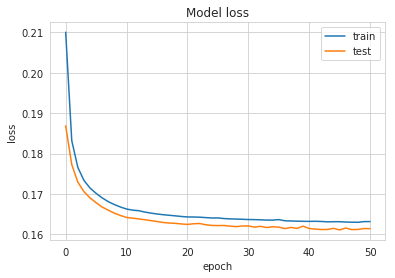

In [65]:
best_loss_value_spae_sigmoid_adam_mse  = plot_hist_auto(hist_spae_sigmoid_adam_mse, './Figures/hist_spae_sigmoid_adam_mse.png')

In [66]:
loss_valueDict = {
    'loss_value_ae_sigmoid_adam_mse': best_loss_value_ae_sigmoid_adam_mse,
    'loss_value_spae_sigmoid_adam_mse': best_loss_value_spae_sigmoid_adam_mse
    }

In [67]:
loss_valueDict

{'loss_value_ae_sigmoid_adam_mse': 0.15721022270130805,
 'loss_value_spae_sigmoid_adam_mse': 0.1631601486616769}

In [68]:
print(enc_train_x_asam.shape)
print(enc_test_x_asam.shape)

print(enc_train_x_spsam.shape)
print(enc_test_x_spsam.shape)

(859156, 44)
(268487, 44)
(859156, 44)
(268487, 44)


### **---------- ANN with ae encoded DS ----------**

In [69]:
ae_ann_2h_unisoftsigbinlosadam1 = ann_2h(neurons=neurons,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 66)                2970      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3350      
_________________________________________________________________
dense_5 (Dense)              (None, 33)                1683      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33)                132       
_________________________________________________________________
dropout_1 (Dropout)          (None, 33)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 34        
Total params: 8,169
Trainable params: 8,103
Non-trainable params: 66
_________________________________________________________________
None


In [70]:
hist_ae_ann_2h_unisoftsigbinlosadam = ann_fit(checkpoint_file = "./H5files/ae_ann_2h_unisoftsigbinlosadam_redds"+str(dsnum)+"bal.h5",
                                        ann = ae_ann_2h_unisoftsigbinlosadam1,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = batch_size)

Tue Jul  9 19:01:38 2019
Train on 687324 samples, validate on 171832 samples
Epoch 1/200
687324/687324 [==============================] - 38s 56us/step - loss: 0.3694 - acc: 0.8190 - val_loss: 0.2804 - val_acc: 0.8671

Epoch 00001: val_loss improved from inf to 0.28043, saving model to ./H5files/ae_ann_2h_unisoftsigbinlosadam_redds20bal.h5
Epoch 2/200
687324/687324 [==============================] - 38s 55us/step - loss: 0.2290 - acc: 0.8931 - val_loss: 0.1988 - val_acc: 0.9095

Epoch 00002: val_loss improved from 0.28043 to 0.19884, saving model to ./H5files/ae_ann_2h_unisoftsigbinlosadam_redds20bal.h5
Epoch 3/200
687324/687324 [==============================] - 37s 54us/step - loss: 0.1937 - acc: 0.9096 - val_loss: 0.1632 - val_acc: 0.9243

Epoch 00003: val_loss improved from 0.19884 to 0.16324, saving model to ./H5files/ae_ann_2h_unisoftsigbinlosadam_redds20bal.h5
Epoch 4/200
687324/687324 [==============================] - 37s 54us/step - loss: 0.1749 - acc: 0.9181 - val_loss: 0.16

In [71]:
# hist_ae_ann_2h_unisoftsigbinlosadam.model.get_weights()

In [72]:
# best_loss_value_ae_ann_2h_unisoftsigbinlosadam = plot_hist_auto(hist_ae_ann_2h_unisoftsigbinlosadam, './Figures/ae_ann_2h_unisoftsigbinlosadam'+str(dsnum)+'.png')

In [73]:
# pred_ae_ann_2h_prob_unisoftsigbinlosadam, pred_ae_ann_2h_01_unisoftsigbinlosadam = ann_predict(ae_ann_2h_unisoftsigbinlosadam,enc_test_x_asam)

In [74]:
# plot_roc_cm(pred_ae_ann_2h_01_unisoftsigbinlosadam, pred_ae_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_ae_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png', './Figures/CM_ae_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png')

In [75]:
enc_train_x=enc_train_x_asam
input_dim=enc_train_x.shape[1]
enc_test_x=enc_test_x_asam
test_y=test_y
train_y=train_y
init_mode='uniform'
activation_input='relu'
weight_constraint=5
dropout_rate=0.0
activation_output='sigmoid'
loss='binary_crossentropy'
optimizer='Adam'

epochs=100

In [76]:
pred_ae_ann_2h_prob_unisoftsigbinlosadam,pred_ae_ann_2h_01_unisoftsigbinlosadam = ann_predict_()

Tue Jul  9 19:26:44 2019
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 66)                2970      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                3350      
_________________________________________________________________
dense_9 (Dense)              (None, 33)                1683      
_________________________________________________________________
batch_normalization_2 (Batch (None, 33)                132       
_________________________________________________________________
dropout_2 (Dropout)          (None, 33)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 34        
Total params: 8,169
Trainable params: 8,103
Non-trainable params: 66
________________________________________________

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
214789/214789 [==============================] - 9s 42us/step - loss: 0.4865 - acc: 0.7486
Epoch 2/100
214789/214789 [==============================] - 9s 41us/step - loss: 0.3209 - acc: 0.8500
Epoch 3/100
214789/214789 [==============================] - 9s 41us/step - loss: 0.2671 - acc: 0.8773
Epoch 4/100
214789/214789 [==============================] - 9s 40us/step - loss: 0.2380 - acc: 0.8909
Epoch 5/100
214789/214789 [==============================] - 9s 40us/step - loss: 0.2184 - acc: 0.9002
Epoch 6/100
214789/214789 [==============================] - 9s 41us/step - loss: 0.2050 - acc: 0.9066
Epoch 7/100
214789/214789 [==============================] - 9s 40us/step - loss: 0.1930 - acc: 0.9124
Epoch 8/100
214789/214789 [==============================] - 9s 41us/step - loss: 0.1846 - acc: 0.9162
Epoch 9/100
214789/214789 [==============================] - 9s 41us/step - loss: 0.1766 - acc: 0.9194
Epoch 10/100
214789/214789 [==============================] - 9s 40us/ste

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 74.0min finished


              precision    recall  f1-score   support

           0     0.9642    0.9582    0.9612    134675
           1     0.9582    0.9641    0.9612    133812

   micro avg     0.9612    0.9612    0.9612    268487
   macro avg     0.9612    0.9612    0.9612    268487
weighted avg     0.9612    0.9612    0.9612    268487



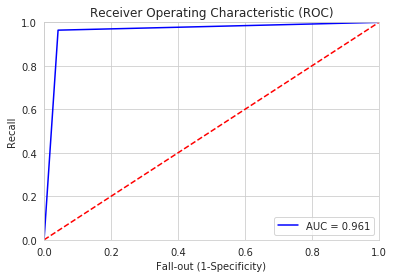

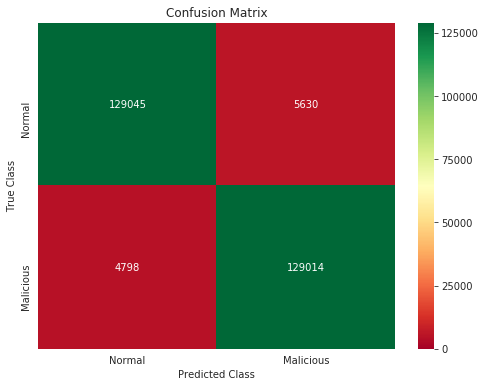

In [77]:
plot_roc_cm(pred_ae_ann_2h_01_unisoftsigbinlosadam, pred_ae_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_ae_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png', './Figures/CM_ae_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png')

### **---------- ANN with spae encoded DS ----------**

In [78]:
sp_ann_2h_unisoftsigbinlosadam1 = ann_2h(neurons=neurons,
                                      encoded_train_x=enc_train_x_spsam,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 66)                2970      
_________________________________________________________________
dense_28 (Dense)             (None, 50)                3350      
_________________________________________________________________
dense_29 (Dense)             (None, 33)                1683      
_________________________________________________________________
batch_normalization_7 (Batch (None, 33)                132       
_________________________________________________________________
dropout_7 (Dropout)          (None, 33)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 34        
Total params: 8,169
Trainable params: 8,103
Non-trainable params: 66
_________________________________________________________________
None


In [79]:
hist_sp_ann_2h_unisoftsigbinlosadam = ann_fit(checkpoint_file = "./H5files/ann_2h_unisoftsigbinlosadam_redds"+str(dsnum)+"bal.h5",
                                        ann = sp_ann_2h_unisoftsigbinlosadam1,
                                        enc_train_x = enc_train_x_spsam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = batch_size)

Tue Jul  9 20:40:45 2019
Train on 687324 samples, validate on 171832 samples
Epoch 1/200
687324/687324 [==============================] - 32s 46us/step - loss: 0.3452 - acc: 0.8343 - val_loss: 0.2639 - val_acc: 0.8795

Epoch 00001: val_loss improved from inf to 0.26390, saving model to ./H5files/ann_2h_unisoftsigbinlosadam_redds20bal.h5
Epoch 2/200
687324/687324 [==============================] - 31s 45us/step - loss: 0.2052 - acc: 0.9075 - val_loss: 0.1758 - val_acc: 0.9209

Epoch 00002: val_loss improved from 0.26390 to 0.17582, saving model to ./H5files/ann_2h_unisoftsigbinlosadam_redds20bal.h5
Epoch 3/200
687324/687324 [==============================] - 31s 45us/step - loss: 0.1704 - acc: 0.9237 - val_loss: 0.1366 - val_acc: 0.9413

Epoch 00003: val_loss improved from 0.17582 to 0.13662, saving model to ./H5files/ann_2h_unisoftsigbinlosadam_redds20bal.h5
Epoch 4/200
687324/687324 [==============================] - 31s 45us/step - loss: 0.1512 - acc: 0.9315 - val_loss: 0.1358 - val_

In [80]:
# hist_sp_ann_2h_unisoftsigbinlosadam.model.get_weights()

In [81]:
# best_loss_value_sp_ann_2h_unisoftsigbinlosadam = plot_hist_auto(hist_sp_ann_2h_unisoftsigbinlosadam, './Figures/sp_ann_2h_unisoftsigbinlosadam'+str(dsnum)+'.png')

In [82]:
# pred_sp_ann_2h_prob_unisoftsigbinlosadam, pred_sp_ann_2h_01_unisoftsigbinlosadam = ann_predict(sp_ann_2h_unisoftsigbinlosadam,enc_test_x_spsam)

In [83]:
# plot_roc_cm(pred_sp_ann_2h_prob_unisoftsigbinlosadam, pred_sp_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_sp_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png', './Figures/CM_sp_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png')

In [84]:
enc_train_x=enc_train_x_asam
input_dim=enc_train_x.shape[1]
enc_test_x=enc_test_x_spsam
test_y=test_y
train_y=train_y
init_mode='uniform'
activation_input='relu'
weight_constraint=5
dropout_rate=0.0
activation_output='sigmoid'
loss='binary_crossentropy'
optimizer='Adam'

epochs=100

In [85]:
pred_sp_ann_2h_prob_unisoftsigbinlosadam,pred_sp_ann_2h_01_unisoftsigbinlosadam = ann_predict_()

Tue Jul  9 21:04:46 2019
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 66)                2970      
_________________________________________________________________
dense_32 (Dense)             (None, 50)                3350      
_________________________________________________________________
dense_33 (Dense)             (None, 33)                1683      
_________________________________________________________________
batch_normalization_8 (Batch (None, 33)                132       
_________________________________________________________________
dropout_8 (Dropout)          (None, 33)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 34        
Total params: 8,169
Trainable params: 8,103
Non-trainable params: 66
________________________________________________

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
214789/214789 [==============================] - 10s 47us/step - loss: 0.4771 - acc: 0.7532
Epoch 2/100
214789/214789 [==============================] - 9s 43us/step - loss: 0.3185 - acc: 0.8521
Epoch 3/100
214789/214789 [==============================] - 9s 43us/step - loss: 0.2577 - acc: 0.8838
Epoch 4/100
214789/214789 [==============================] - 9s 43us/step - loss: 0.2268 - acc: 0.8977
Epoch 5/100
214789/214789 [==============================] - 9s 43us/step - loss: 0.2068 - acc: 0.9071
Epoch 6/100
214789/214789 [==============================] - 9s 43us/step - loss: 0.1897 - acc: 0.9145
Epoch 7/100
214789/214789 [==============================] - 9s 43us/step - loss: 0.1793 - acc: 0.9193
Epoch 8/100
214789/214789 [==============================] - 9s 43us/step - loss: 0.1698 - acc: 0.9231
Epoch 9/100
214789/214789 [==============================] - 9s 43us/step - loss: 0.1606 - acc: 0.9280
Epoch 10/100
214789/214789 [==============================] - 9s 43us/st

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 78.1min finished


              precision    recall  f1-score   support

           0     0.9725    0.9661    0.9693    134675
           1     0.9661    0.9725    0.9693    133812

   micro avg     0.9693    0.9693    0.9693    268487
   macro avg     0.9693    0.9693    0.9693    268487
weighted avg     0.9693    0.9693    0.9693    268487



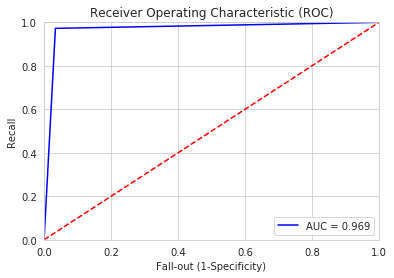

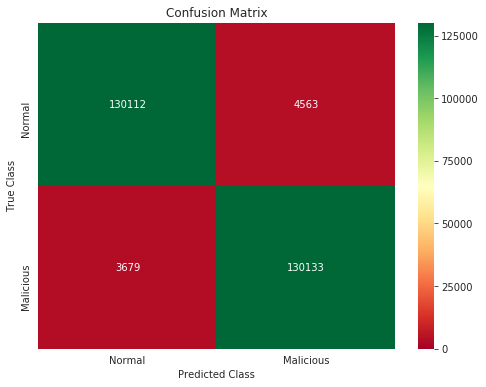

In [86]:
plot_roc_cm(pred_sp_ann_2h_prob_unisoftsigbinlosadam, pred_sp_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_sp_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png', './Figures/CM_sp_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png')

### **---------- ANN with no encoded DS ----------**

In [87]:
nodr_ann_2h_unisoftsigbinlosadam1 = ann_2h(neurons=neurons,
                                      encoded_train_x=train_x,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 66)                4422      
_________________________________________________________________
dense_52 (Dense)             (None, 50)                3350      
_________________________________________________________________
dense_53 (Dense)             (None, 33)                1683      
_________________________________________________________________
batch_normalization_13 (Batc (None, 33)                132       
_________________________________________________________________
dropout_13 (Dropout)         (None, 33)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 34        
Total params: 9,621
Trainable params: 9,555
Non-trainable params: 66
_________________________________________________________________
None


In [88]:
hist_nodr_ann_2h_unisoftsigbinlosadam = ann_fit(checkpoint_file = "./H5files/ann_2h_unisoftsigbinlosadam_redds"+str(dsnum)+"bal.h5",
                                        ann = nodr_ann_2h_unisoftsigbinlosadam1,
                                        enc_train_x = train_x,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = batch_size)

Tue Jul  9 22:22:53 2019
Train on 687324 samples, validate on 171832 samples
Epoch 1/200
687324/687324 [==============================] - 36s 52us/step - loss: 0.2323 - acc: 0.8907 - val_loss: 0.1440 - val_acc: 0.9358

Epoch 00001: val_loss improved from inf to 0.14399, saving model to ./H5files/ann_2h_unisoftsigbinlosadam_redds20bal.h5
Epoch 2/200
687324/687324 [==============================] - 35s 51us/step - loss: 0.1279 - acc: 0.9420 - val_loss: 0.1060 - val_acc: 0.9533

Epoch 00002: val_loss improved from 0.14399 to 0.10601, saving model to ./H5files/ann_2h_unisoftsigbinlosadam_redds20bal.h5
Epoch 3/200
687324/687324 [==============================] - 35s 51us/step - loss: 0.1048 - acc: 0.9528 - val_loss: 0.0879 - val_acc: 0.9624

Epoch 00003: val_loss improved from 0.10601 to 0.08785, saving model to ./H5files/ann_2h_unisoftsigbinlosadam_redds20bal.h5
Epoch 4/200
687324/687324 [==============================] - 35s 51us/step - loss: 0.0911 - acc: 0.9596 - val_loss: 0.0813 - val_

In [89]:
# hist_nodr_ann_2h_unisoftsigbinlosadam.model.get_weights()

In [90]:
# best_loss_value_nodr_ann_2h_unisoftsigbinlosadam = plot_hist_auto(hist_nodr_ann_2h_unisoftsigbinlosadam, './Figures/nodr_ann_2h_unisoftsigbinlosadam'+str(dsnum)+'.png')

In [91]:
# pred_nodr_ann_2h_prob_unisoftsigbinlosadam, pred_nodr_ann_2h_01_unisoftsigbinlosadam = ann_predict(nodr_ann_2h_unisoftsigbinlosadam,test_x)

In [92]:
# plot_roc_cm(pred_nodr_ann_2h_01_unisoftsigbinlosadam, pred_nodr_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_nodr_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png', './Figures/CM_nodr_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png')

In [93]:
enc_train_x=train_x
input_dim=enc_train_x.shape[1]
enc_test_x=test_x
test_y=test_y
train_y=train_y
init_mode='uniform'
activation_input='relu'
weight_constraint=5
dropout_rate=0.0
activation_output='sigmoid'
loss='binary_crossentropy'
optimizer='Adam'

epochs=100

In [94]:
pred_nodr_ann_2h_prob_unisoftsigbinlosadam, pred_nodr_ann_2h_01_unisoftsigbinlosadam = ann_predict_()

Tue Jul  9 22:42:57 2019


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 66)                4422      
_________________________________________________________________
dense_56 (Dense)             (None, 50)                3350      
_________________________________________________________________
dense_57 (Dense)             (None, 33)                1683      
_________________________________________________________________
batch_normalization_14 (Batc (None, 33)                132       
_________________________________________________________________
dropout_14 (Dropout)         (None, 33)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 34        
Total params: 9,621
Trainable params: 9,555
Non-trainable params: 66
_________________________________________________________________
None
Ep

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 82.2min finished


              precision    recall  f1-score   support

           0     0.9854    0.9809    0.9831    134675
           1     0.9809    0.9854    0.9831    133812

   micro avg     0.9831    0.9831    0.9831    268487
   macro avg     0.9831    0.9831    0.9831    268487
weighted avg     0.9831    0.9831    0.9831    268487



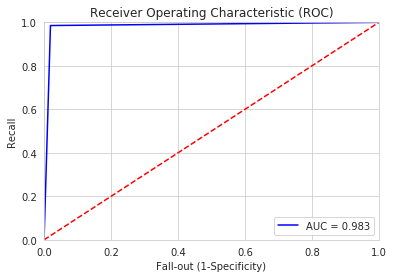

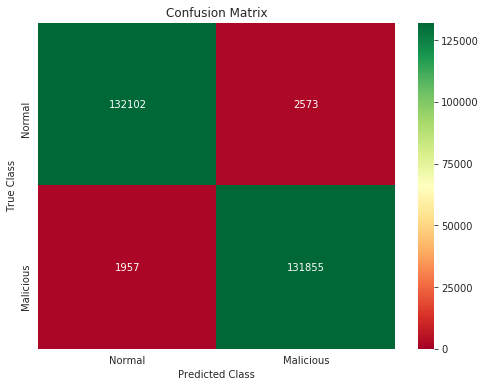

In [95]:
plot_roc_cm(pred_nodr_ann_2h_01_unisoftsigbinlosadam, pred_nodr_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_nodr_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png', './Figures/CM_nodr_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png')

### **---------- RF with ae encoded DS ----------**

In [96]:
# from sklearn.ensemble import RandomForestClassifier

In [97]:
# pca_ = PCA(n_components = 0.95, svd_solver = 'full').fit(train_x)

# plt.figure(figsize=(8,5))
# n_coml = [pca_.n_components_]

# plt.plot(np.cumsum(pca_.explained_variance_ratio_))
# plt.xlabel('Number of Components', fontsize=14)
# plt.ylabel('Variance (%)', fontsize=14) #for each component
# plt.title('Pulsar Dataset Explained Variance '+str(dsnum)+' node DS', fontsize=14)

# n_coml = [*n_coml]

# for i, v in enumerate(n_coml):
#     plt.text(v-0.8, i+0.94, '{:.0f}'.format(v), color='navy', fontsize=14)

# plt.savefig('./Figures/PCA_components_ds'+str(dsnum)+'bal.png')
# plt.show()

In [98]:
# clf = RandomForestClassifier(n_estimators=300, 
#                              criterion='gini', 
#                              max_depth=16, 
#                              #min_samples_split=2, 
#                              #min_samples_leaf=1, 
#                              max_features=0.3, 
#                              #bootstrap=True,
#                              oob_score=True,
#                              random_state=23)  

In [99]:
# start_time = datetime.now()
# print(datetime.ctime(start_time))

# clf.fit(enc_train_x_asam, train_y)

# pred_y_ae_RF = cross_val_predict(estimator=clf,
#                               X=np.array(enc_test_x_asam),
#                               y=test_y,
#                               cv=KFold(n_splits=5, random_state=23),
#                               n_jobs=2)

# time_elapsed = datetime.now() - start_time 
# print("Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))

# print(sm.classification_report(test_y, pred_y_ae_RF,digits=4))

In [100]:
# plot_roc_cm(pred_y_ae_RF, pred_y_ae_RF, './Figures/ROC_ae_rf_E100MaxfautoMaxdnoneBootT_redds'+str(dsnum)+'bal.png', './Figures/CM_ae_rf_E100MaxfautoMaxdnoneBootT_redds'+str(dsnum)+'bal.png')

### **---------- RF with spae encoded DS ----------**

In [101]:
# start_time = datetime.now()
# print(datetime.ctime(start_time))

# clf.fit(enc_train_x_spsam, train_y)

# pred_y_spae_RF = cross_val_predict(estimator=clf,
#                               X=np.array(enc_test_x_spsam),
#                               y=test_y,
#                               cv=KFold(n_splits=5, random_state=23),
#                               n_jobs=2)

# time_elapsed = datetime.now() - start_time 
# print("Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))

# print(sm.classification_report(test_y, pred_y_spae_RF,digits=4))

In [102]:
# plot_roc_cm(pred_y_spae_RF, pred_y_spae_RF, './Figures/ROC_spae_rf_E100MaxfautoMaxdnoneBootT_redds'+str(dsnum)+'bal.png', './Figures/CM_spae_rf_E100MaxfautoMaxdnoneBootT_redds'+str(dsnum)+'bal.png')

### **---------- RF with pca DS ----------**

In [103]:
# start_time = datetime.now()
# print(datetime.ctime(start_time))

# clf.fit(train_x_pca, train_y)

# pred_y_pca_RF = cross_val_predict(estimator=clf,
#                               X=np.array(test_x_pca),
#                               y=test_y,
#                               cv=KFold(n_splits=5, random_state=23),
#                               n_jobs=2)

# time_elapsed = datetime.now() - start_time 
# print("Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))

# print(sm.classification_report(test_y, pred_y_pca_RF,digits=4))

In [104]:
# plot_roc_cm(pred_y_pca_RF, pred_y_pca_RF, './Figures/ROC_pca_rf_E100MaxfautoMaxdnoneBootT_redds'+str(dsnum)+'bal.png', './Figures/CM_pca_rf_E100MaxfautoMaxdnoneBootT_redds'+str(dsnum)+'bal.png')

In [105]:
print(pred_ae_ann_2h_01_unisoftsigbinlosadam.shape)
print(pred_ae_ann_2h_prob_unisoftsigbinlosadam.shape)
print(pred_sp_ann_2h_01_unisoftsigbinlosadam.shape)
print(pred_sp_ann_2h_prob_unisoftsigbinlosadam.shape)
print(pred_nodr_ann_2h_01_unisoftsigbinlosadam.shape)
print(pred_nodr_ann_2h_prob_unisoftsigbinlosadam.shape)
# print(pred_y_ae_RF.shape)
# print(pred_y_spae_RF.shape)
# print(pred_y_pca_RF.shape)

(268487,)
(268487,)
(268487,)
(268487,)
(268487,)
(268487,)


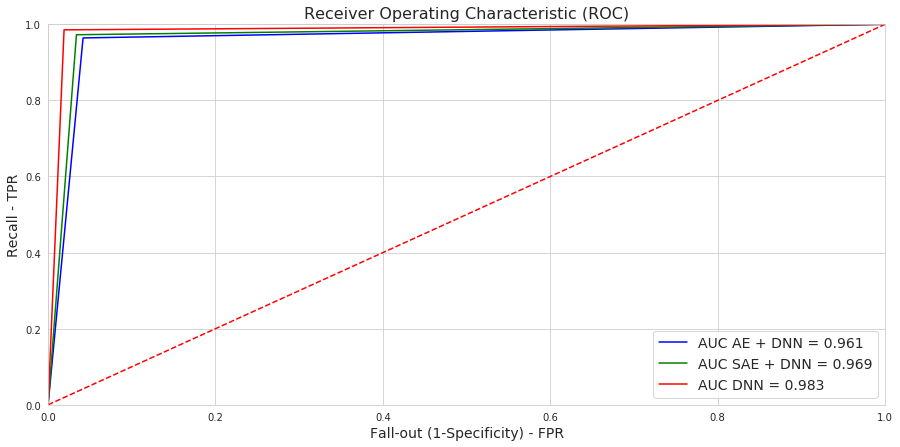

In [106]:
false_positive_rate_ae_ann, recall_ae_ann, thresholds_ae_ann = roc_curve(test_y, pred_ae_ann_2h_01_unisoftsigbinlosadam)
roc_auc_ae_ann = auc(false_positive_rate_ae_ann, recall_ae_ann)
false_positive_rate_sp_ann, recall_sp_ann, thresholds_sp_ann = roc_curve(test_y, pred_sp_ann_2h_01_unisoftsigbinlosadam)
roc_auc_sp_ann = auc(false_positive_rate_sp_ann, recall_sp_ann)
false_positive_rate_nodr_ann, recall_nodr_ann, thresholds_nodr_ann = roc_curve(test_y, pred_nodr_ann_2h_01_unisoftsigbinlosadam)
roc_auc_nodr_ann = auc(false_positive_rate_nodr_ann, recall_nodr_ann)

# false_positive_rate_ae_RF, recall_ae_RF, thresholds_ae_RF = roc_curve(test_y, pred_y_ae_RF)
# roc_auc_ae_RF = auc(false_positive_rate_ae_RF, recall_ae_RF)
# false_positive_rate_spae_RF, recall_spae_RF, thresholds_spae_RF = roc_curve(test_y, pred_y_spae_RF)
# roc_auc_spae_RF = auc(false_positive_rate_spae_RF, recall_spae_RF)
# false_positive_rate_pca_RF, recall_pca_RF, thresholds_pca_RF = roc_curve(test_y, pred_y_pca_RF)
# roc_auc_pca_RF = auc(false_positive_rate_pca_RF, recall_pca_RF)

plt.figure(figsize=(15,7))
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)

plt.plot(false_positive_rate_ae_ann, recall_ae_ann, 'b', label = 'AUC AE + DNN = %0.3f' %roc_auc_ae_ann)
plt.plot(false_positive_rate_sp_ann, recall_sp_ann, 'g', label = 'AUC SAE + DNN = %0.3f' %roc_auc_sp_ann)
plt.plot(false_positive_rate_nodr_ann, recall_nodr_ann, 'r', label = 'AUC DNN = %0.3f' %roc_auc_nodr_ann)
# plt.plot(false_positive_rate_ae_RF, recall_ae_RF, 'c', label = 'AUC AE + RF = %0.3f' %roc_auc_ae_RF)
# plt.plot(false_positive_rate_spae_RF, recall_spae_RF, 'm', label = 'AUC SAE + RF = %0.3f' %roc_auc_spae_RF)
# plt.plot(false_positive_rate_pca_RF, recall_pca_RF, 'black', label = 'AUC PCA + RF = %0.3f' %roc_auc_pca_RF)

plt.legend(loc='lower right', fontsize=14)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
# plt.ylim([0.97,1.0])

plt.ylabel('Recall - TPR', fontsize=14)
plt.xlabel('Fall-out (1-Specificity) - FPR', fontsize=14)
plt.savefig('./Figures/ROC_allmodels'+str(dsnum)+'bal.png')
plt.show()


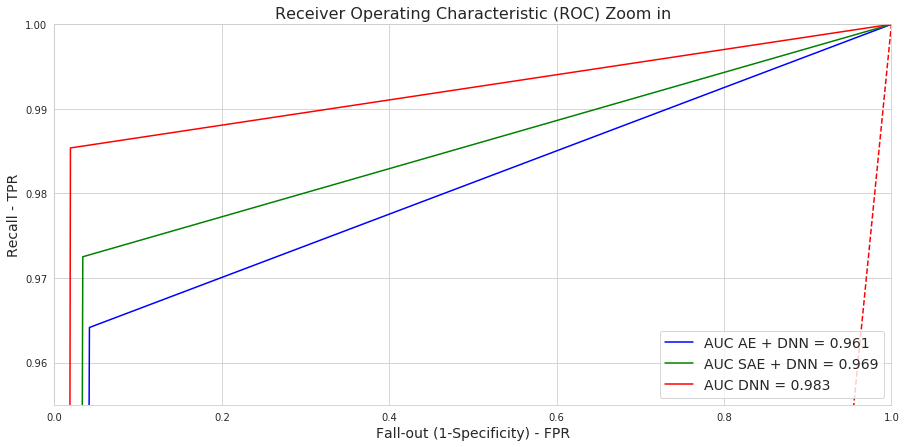

In [107]:
plt.figure(figsize=(15,7))
plt.title('Receiver Operating Characteristic (ROC) Zoom in', fontsize=16)

plt.plot(false_positive_rate_ae_ann, recall_ae_ann, 'b', label = 'AUC AE + DNN = %0.3f' %roc_auc_ae_ann)
plt.plot(false_positive_rate_sp_ann, recall_sp_ann, 'g', label = 'AUC SAE + DNN = %0.3f' %roc_auc_sp_ann)
plt.plot(false_positive_rate_nodr_ann, recall_nodr_ann, 'r', label = 'AUC DNN = %0.3f' %roc_auc_nodr_ann)
# plt.plot(false_positive_rate_ae_RF, recall_ae_RF, 'c', label = 'AUC AE + RF = %0.3f' %roc_auc_ae_RF)
# plt.plot(false_positive_rate_spae_RF, recall_spae_RF, 'm', label = 'AUC SAE + RF = %0.3f' %roc_auc_spae_RF)
# plt.plot(false_positive_rate_pca_RF, recall_pca_RF, 'black', label = 'AUC PCA + RF = %0.3f' %roc_auc_pca_RF)

plt.legend(loc='lower right', fontsize=14)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
# plt.ylim([0.0,1.0])
plt.ylim([0.955,1.0])

plt.ylabel('Recall - TPR', fontsize=14)
plt.xlabel('Fall-out (1-Specificity) - FPR', fontsize=14)
plt.savefig('./Figures/ROC_allmodels'+str(dsnum)+'bal_zoom.png')
plt.show()

In [108]:
classi_ae_ann = "AE+DNN"
acc_ae_ann = (sm.accuracy_score(test_y, pred_ae_ann_2h_01_unisoftsigbinlosadam)*100) 
pre_ae_ann = (sm.precision_score(test_y, pred_ae_ann_2h_01_unisoftsigbinlosadam)*100) 
recall_ae_ann = (sm.recall_score(test_y, pred_ae_ann_2h_01_unisoftsigbinlosadam)*100) 
f1score_ae_ann = (sm.f1_score(test_y, pred_ae_ann_2h_01_unisoftsigbinlosadam)*100)

classi_sp_ann = "SAE+DNN"
acc_sp_ann = (sm.accuracy_score(test_y, pred_sp_ann_2h_01_unisoftsigbinlosadam)*100) 
pre_sp_ann = (sm.precision_score(test_y, pred_sp_ann_2h_01_unisoftsigbinlosadam)*100) 
recall_sp_ann = (sm.recall_score(test_y, pred_sp_ann_2h_01_unisoftsigbinlosadam)*100) 
f1score_sp_ann = (sm.f1_score(test_y, pred_sp_ann_2h_01_unisoftsigbinlosadam)*100)

classi_nodr_ann = "DNN"
acc_nodr_ann = (sm.accuracy_score(test_y, pred_nodr_ann_2h_01_unisoftsigbinlosadam)*100) 
pre_nodr_ann = (sm.precision_score(test_y, pred_nodr_ann_2h_01_unisoftsigbinlosadam)*100) 
recall_nodr_ann = (sm.recall_score(test_y, pred_nodr_ann_2h_01_unisoftsigbinlosadam)*100) 
f1score_nodr_ann = (sm.f1_score(test_y, pred_nodr_ann_2h_01_unisoftsigbinlosadam)*100)

# classi_ae_RF = "AE+RF"
# acc_ae_RF = (sm.accuracy_score(test_y, pred_y_ae_RF)*100) 
# pre_ae_RF = (sm.precision_score(test_y, pred_y_ae_RF)*100) 
# recall_ae_RF = (sm.recall_score(test_y, pred_y_ae_RF)*100) 
# f1score_ae_RF = (sm.f1_score(test_y, pred_y_ae_RF)*100)

# classi_spae_RF = "SAE+RF"
# acc_spae_RF = (sm.accuracy_score(test_y, pred_y_spae_RF)*100) 
# pre_spae_RF = (sm.precision_score(test_y, pred_y_spae_RF)*100) 
# recall_spae_RF = (sm.recall_score(test_y, pred_y_spae_RF)*100) 
# f1score_spae_RF = (sm.f1_score(test_y, pred_y_spae_RF)*100)

# classi_pca_RF = "PCA+RF"
# acc_pca_RF = (sm.accuracy_score(test_y, pred_y_pca_RF)*100) 
# pre_pca_RF = (sm.precision_score(test_y, pred_y_pca_RF)*100) 
# recall_pca_RF = (sm.recall_score(test_y, pred_y_pca_RF)*100) 
# f1score_pca_RF = (sm.f1_score(test_y, pred_y_pca_RF)*100)


print('Classifier\tAcc\tPreci\tRecall\tF1Score')
print('{0:}\t\t{1:.2f}\t{2:.2f}\t{3:.2f}\t{4:.2f}'.format(classi_ae_ann, acc_ae_ann, pre_ae_ann, recall_ae_ann, f1score_ae_ann))
print('{0:}\t\t{1:.2f}\t{2:.2f}\t{3:.2f}\t{4:.2f}'.format(classi_sp_ann, acc_sp_ann, pre_sp_ann, recall_sp_ann, f1score_sp_ann))
print('{0:}\t\t{1:.2f}\t{2:.2f}\t{3:.2f}\t{4:.2f}'.format(classi_nodr_ann, acc_nodr_ann, pre_nodr_ann, recall_nodr_ann, f1score_nodr_ann))
# print('{0:}\t\t{1:.2f}\t{2:.2f}\t{3:.2f}\t{4:.2f}'.format(classi_ae_RF, acc_ae_RF, pre_ae_RF, recall_ae_RF, f1score_ae_RF))
# print('{0:}\t\t{1:.2f}\t{2:.2f}\t{3:.2f}\t{4:.2f}'.format(classi_spae_RF, acc_spae_RF, pre_spae_RF, recall_spae_RF, f1score_spae_RF))
# print('{0:}\t\t{1:.2f}\t{2:.2f}\t{3:.2f}\t{4:.2f}'.format(classi_pca_RF, acc_pca_RF, pre_pca_RF, recall_pca_RF, f1score_pca_RF))

Classifier	Acc	Preci	Recall	F1Score
AE+DNN		96.12	95.82	96.41	96.12
SAE+DNN		96.93	96.61	97.25	96.93
DNN		98.31	98.09	98.54	98.31


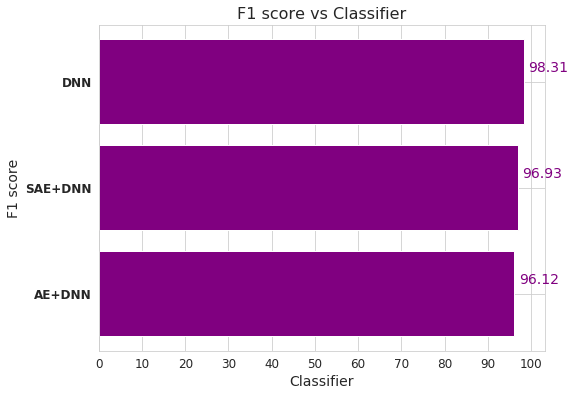

In [109]:
f1list = [["AE+DNN",f1score_ae_ann],["SAE+DNN",f1score_sp_ann],["DNN",f1score_nodr_ann]]#,
#           ["AE+RF",f1score_ae_RF],["SAE+RF",f1score_spae_RF],["PCA+RF",f1score_pca_RF]]

xs, ys = [*zip(*f1list)]

'{:.2f}'.format(f1score_ae_ann)

plt.figure(figsize=(8,6), )
plt.barh(xs, ys, color = "purple")
plt.title("F1 score vs Classifier", fontsize=16)
plt.xlabel("Classifier", fontsize=14)
plt.ylabel("F1 score", fontsize=14)
plt.xticks(np.arange(0, 101, 10), fontsize=12)
plt.yticks(fontsize=12, fontweight='bold')

for i, v in enumerate(ys):
    plt.text(v+1, i+0.1, '{:.2f}'.format(v), color='purple', fontsize=14)

plt.savefig('./Figures/F1scoreplot_allmodels'+str(dsnum)+'bal.png')
plt.show()
